In [ ]:
!pip install holidays

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.7/824.7 kB 11.4 MB/s eta 0:00:00


In [ ]:
!pip install prophet==1.1.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 5.6 MB/s eta 0:00:00


In [ ]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 14.1 MB/s eta 0:00:00


In [ ]:
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 3.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import folium
from folium.plugins import HeatMap
import plotly.express as px

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/GDG/Research Paper/Datasets/Clean_LA_Crime.csv')

In [ ]:
df['DateTime'] = pd.to_datetime(df['DATE OCC'].astype(str) + ' ' + df['TIME OCC'].astype(str))

In [ ]:
df_prophet = df[['DateTime', 'Crm Cd Desc']].groupby(['DateTime']).size().reset_index(name='crime_count')
df_prophet.columns = ['ds', 'y']

# Hyperparameter Tuning and Cross Validation

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

In [ ]:
def prophet_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [ ]:
def cross_validate_prophet(param_grid, df_prophet):
    # Split the data into train and test
    train, test = train_test_split(df_prophet, test_size=0.2, shuffle=False)

    # Set up TimeSeriesSplit cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    best_params = None
    best_mse = float('inf')

    # Loop through all parameter combinations
    for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
        for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
            print(f"Testing with changepoint_prior_scale={changepoint_prior_scale}, seasonality_prior_scale={seasonality_prior_scale}")

            # **Instantiate a new Prophet model for each combination of hyperparameters**
            mse_list = []
            for train_idx, val_idx in tscv.split(train):
                # Split the data for the current fold
                train_fold, val_fold = train.iloc[train_idx], train.iloc[val_idx]

                # Instantiate a new Prophet model for each fold
                prophet_model = Prophet(
                    changepoint_prior_scale=changepoint_prior_scale,
                    seasonality_prior_scale=seasonality_prior_scale
                )

                # Fit the model on the training data
                prophet_model.fit(train_fold)

                # Make predictions on the validation fold
                forecast = prophet_model.predict(val_fold)
                y_pred = forecast['yhat'].values
                y_true = val_fold['y'].values

                # Calculate MSE for this fold
                mse = prophet_mse(y_true, y_pred)
                mse_list.append(mse)

            # Calculate average MSE for current parameter combination
            avg_mse = np.mean(mse_list)
            print(f"Avg MSE: {avg_mse}")

            # If the current combination is better, store the results
            if avg_mse < best_mse:
                best_mse = avg_mse
                best_params = {
                    'changepoint_prior_scale': changepoint_prior_scale,
                    'seasonality_prior_scale': seasonality_prior_scale
                }

    return best_params, best_mse

In [ ]:
best_params, best_mse = cross_validate_prophet(param_grid, df_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Testing with changepoint_prior_scale=0.001, seasonality_prior_scale=0.01


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/qp6xufxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/bkhju1pi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67484', 'data', 'file=/tmp/tmp0tz_j5q6/qp6xufxu.json', 'init=/tmp/tmp0tz_j5q6/bkhju1pi.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_modelcufynhu6/prophet_model-20250310124904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:49:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:49:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/phy8_1jk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/5i5coj9v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Avg MSE: 13.336555420985773
Testing with changepoint_prior_scale=0.001, seasonality_prior_scale=0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/urzv1kee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78528', 'data', 'file=/tmp/tmp0tz_j5q6/k6wc2mso.json', 'init=/tmp/tmp0tz_j5q6/urzv1kee.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_model68rinu16/prophet_model-20250310125326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:53:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:53:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/stnglkdy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/q9ykd42x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Avg MSE: 13.33334598493081
Testing with changepoint_prior_scale=0.001, seasonality_prior_scale=1.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/4i2j_4m_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28073', 'data', 'file=/tmp/tmp0tz_j5q6/qh6bofjn.json', 'init=/tmp/tmp0tz_j5q6/4i2j_4m_.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_modelbwmc_5pu/prophet_model-20250310125816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:58:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:58:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/kosp6p1_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/s8tl9orn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Avg MSE: 13.3326914816384
Testing with changepoint_prior_scale=0.001, seasonality_prior_scale=10.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/mropvnc1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3606', 'data', 'file=/tmp/tmp0tz_j5q6/0ouxadkg.json', 'init=/tmp/tmp0tz_j5q6/mropvnc1.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_model7qul8cof/prophet_model-20250310130345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:03:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/g0b6xbsh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/4mk2fnjp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bi

Avg MSE: 13.334260991415873
Testing with changepoint_prior_scale=0.01, seasonality_prior_scale=0.01


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/fe6hj2dg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93743', 'data', 'file=/tmp/tmp0tz_j5q6/9lytumnc.json', 'init=/tmp/tmp0tz_j5q6/fe6hj2dg.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_model691vs87k/prophet_model-20250310130849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:08:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:09:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/wzv2bn54.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/oax53psc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Avg MSE: 13.336676328953418
Testing with changepoint_prior_scale=0.01, seasonality_prior_scale=0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/cwjrsxw8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/q677ttbj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65642', 'data', 'file=/tmp/tmp0tz_j5q6/cwjrsxw8.json', 'init=/tmp/tmp0tz_j5q6/q677ttbj.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_model9z_l0w_j/prophet_model-20250310131418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:14:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:14:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/phbj_cd4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/_9bojbkv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Avg MSE: 13.432911724508175
Testing with changepoint_prior_scale=0.01, seasonality_prior_scale=1.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/bfer_l_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97055', 'data', 'file=/tmp/tmp0tz_j5q6/mrqn7dt4.json', 'init=/tmp/tmp0tz_j5q6/bfer_l_3.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_modele6tzf3fg/prophet_model-20250310131907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/sjw41ozl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/pxvy1tc5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Avg MSE: 13.384273061293534
Testing with changepoint_prior_scale=0.01, seasonality_prior_scale=10.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/07e7bpdn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/4wl747co.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49260', 'data', 'file=/tmp/tmp0tz_j5q6/07e7bpdn.json', 'init=/tmp/tmp0tz_j5q6/4wl747co.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_modeles15e_tw/prophet_model-20250310132357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/escj7l20.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/vjow2kar.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Avg MSE: 13.375652887369691
Testing with changepoint_prior_scale=0.1, seasonality_prior_scale=0.01


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/7b7lxt57.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31127', 'data', 'file=/tmp/tmp0tz_j5q6/ac7urpf3.json', 'init=/tmp/tmp0tz_j5q6/7b7lxt57.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_modelr3ah3k2y/prophet_model-20250310132842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:28:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:28:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/gywvbs2_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/ipf607tl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Avg MSE: 19.481539140909728
Testing with changepoint_prior_scale=0.1, seasonality_prior_scale=0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/n3h6zzto.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/b82742zp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65461', 'data', 'file=/tmp/tmp0tz_j5q6/n3h6zzto.json', 'init=/tmp/tmp0tz_j5q6/b82742zp.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_model_p47y1v4/prophet_model-20250310133207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:32:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:32:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/4hsr8yj6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/p5hlo3j0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Avg MSE: 18.828925400940545
Testing with changepoint_prior_scale=0.1, seasonality_prior_scale=1.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/kacpov7o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74002', 'data', 'file=/tmp/tmp0tz_j5q6/hlw9bxva.json', 'init=/tmp/tmp0tz_j5q6/kacpov7o.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_modelvfjqnodm/prophet_model-20250310133537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/vek9v2a3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/9wt4rbzs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Avg MSE: 22.035124828139192
Testing with changepoint_prior_scale=0.1, seasonality_prior_scale=10.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/k6oecw3e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/89xkghua.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13295', 'data', 'file=/tmp/tmp0tz_j5q6/k6oecw3e.json', 'init=/tmp/tmp0tz_j5q6/89xkghua.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_modelxn1vv7jy/prophet_model-20250310133918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:39:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:39:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/0nc5ikhh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/hnsnxium.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Avg MSE: 19.5543881583844
Testing with changepoint_prior_scale=1.0, seasonality_prior_scale=0.01


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/6_wkrf1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54418', 'data', 'file=/tmp/tmp0tz_j5q6/caet2wao.json', 'init=/tmp/tmp0tz_j5q6/6_wkrf1q.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_model_rwhvdcp/prophet_model-20250310134223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:42:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:42:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/36kq06k8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/mclcysyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Avg MSE: 22.158104216608407
Testing with changepoint_prior_scale=1.0, seasonality_prior_scale=0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/v9nk866i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81588', 'data', 'file=/tmp/tmp0tz_j5q6/ns635q86.json', 'init=/tmp/tmp0tz_j5q6/v9nk866i.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_modeli9ykw4nf/prophet_model-20250310134546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:45:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/qlm6xjct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/zo2ka016.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Avg MSE: 25.07479970107613
Testing with changepoint_prior_scale=1.0, seasonality_prior_scale=1.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/sqkbi8cq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44292', 'data', 'file=/tmp/tmp0tz_j5q6/687ek198.json', 'init=/tmp/tmp0tz_j5q6/sqkbi8cq.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_modelt9eqt2nn/prophet_model-20250310134919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:49:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:49:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/8x2yaj10.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/7usofnqb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Avg MSE: 24.30636344378207
Testing with changepoint_prior_scale=1.0, seasonality_prior_scale=10.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/2g1_4bjv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59054', 'data', 'file=/tmp/tmp0tz_j5q6/gsft1udk.json', 'init=/tmp/tmp0tz_j5q6/2g1_4bjv.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_model2nrawzd1/prophet_model-20250310135254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:52:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:53:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/032td29q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/32o_8ujx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Avg MSE: 22.027360806960484


In [ ]:
print("Best parameters:", best_params)
print("Best MSE:", best_mse)

Best parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}
Best MSE: 13.3326914816384


In [ ]:
best_prophet_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)

In [ ]:
best_prophet_model.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/z433heka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/2hftuhu_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65846', 'data', 'file=/tmp/tmp0tz_j5q6/z433heka.json', 'init=/tmp/tmp0tz_j5q6/2hftuhu_.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_modellj2rc5tw/prophet_model-20250310135702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:57:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:01:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = best_prophet_model.make_future_dataframe(periods=24, freq='H')
forecast_prophet = best_prophet_model.predict(future)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


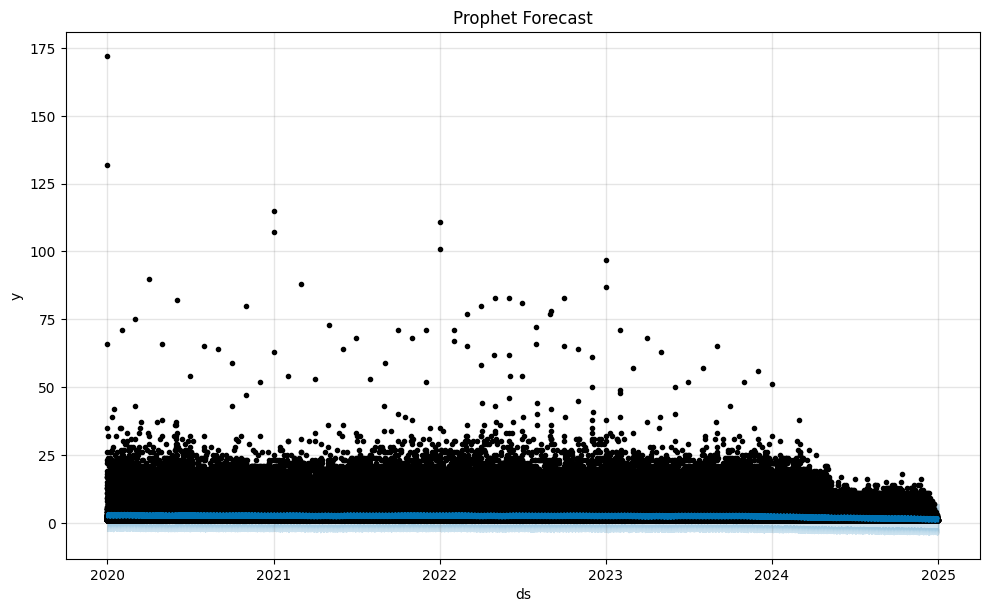

In [ ]:
fig = best_prophet_model.plot(forecast_prophet)
plt.title("Prophet Forecast")
plt.show()

# 24 Hours Forecasting with (5, 1, 0)

In [ ]:
prophet_forecast = forecast_prophet.tail(24)['yhat']

In [ ]:
df_resampled = df.resample('H', on='DateTime').size()

<ipython-input-76-3eb0d8b79523>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('H', on='DateTime').size()


In [ ]:
train_data = df_resampled[:-24]
test_data = df_resampled[-24:]

In [ ]:
train_data_with_prophet = train_data.copy()
train_data_with_prophet = train_data_with_prophet.reset_index(drop=True)
train_data_with_prophet = train_data_with_prophet.to_frame(name='y')

In [ ]:
train_data_with_prophet['prophet_forecast'] = np.concatenate([np.zeros(len(train_data)-len(prophet_forecast)), prophet_forecast])

In [ ]:
arima_param_grid = {
    'order': [(p, d, q) for p in range(1, 6) for d in range (0, 2) for q in range(0, 2)],
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
best_arima_score = float('inf')
best_arima_order = None

In [ ]:
for arima_order in arima_param_grid['order']:
    arima_scores = []

    # Perform cross-validation manually
    for train_index, val_index in tscv.split(train_data_with_prophet):
        train, val = train_data_with_prophet.iloc[train_index], train_data_with_prophet.iloc[val_index]

        # Define and fit the ARIMA model on the training set
        arima_model = ARIMA(train['y'], exog=train['prophet_forecast'], order=arima_order)
        arima_model_fit = arima_model.fit()

        # Forecast the validation set
        forecast = arima_model_fit.forecast(steps=len(val), exog=val['prophet_forecast'])

        # Calculate Mean Squared Error for this fold
        mse = mean_squared_error(val['y'], forecast)
        arima_scores.append(mse)

    # Calculate the average MSE for the current ARIMA order
    avg_mse = np.mean(arima_scores)
    if avg_mse < best_arima_score:
        best_arima_score = avg_mse
        best_arima_order = arima_order

# Print best ARIMA order based on cross-validation
print(f"Best ARIMA order: {best_arima_order}")

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best ARIMA order: (3, 0, 0)


In [ ]:
print("Best ARIMA order:", best_arima_order)

Best ARIMA order: (3, 0, 0)


In [ ]:
print(best_arima_score)

154.65322239251364


In [ ]:
arima_model = ARIMA(train_data_with_prophet['y'], exog=train_data_with_prophet['prophet_forecast'], order=(5, 1, 0))
arima_model_fit = arima_model.fit()

In [ ]:
forecast_arima = arima_model_fit.forecast(steps=24, exog=prophet_forecast)

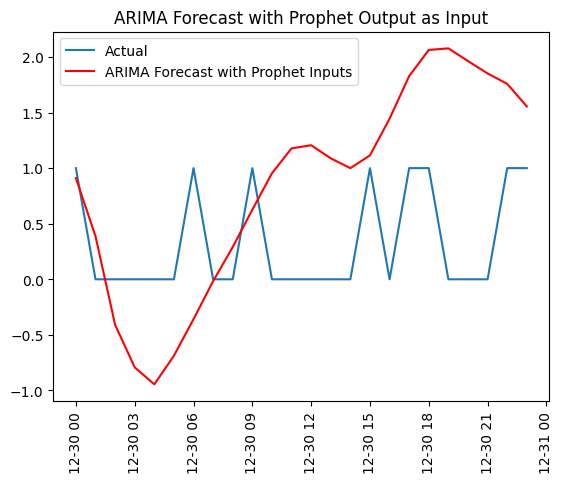

In [ ]:
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, forecast_arima, label='ARIMA Forecast with Prophet Inputs', color='red')
plt.legend()
plt.xticks(rotation=90)
plt.title("ARIMA Forecast with Prophet Output as Input")
plt.show()

In [ ]:
mse_arima = mean_squared_error(test_data, forecast_arima)
rmse_arima = np.sqrt(mse_arima)

model_metrics = {
    'MSE': [mse_arima],
    'RMSE': [rmse_arima]
}

print(model_metrics)

{'MSE': [1.1132979231130156], 'RMSE': [1.0551293395186276]}


# 1 Week Forecasting with (5, 1, 0)

In [ ]:
best_prophet_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)

best_prophet_model.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/53xlr6u3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/8pouvpel.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74792', 'data', 'file=/tmp/tmp0tz_j5q6/53xlr6u3.json', 'init=/tmp/tmp0tz_j5q6/8pouvpel.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_modelpgim_jaq/prophet_model-20250310150910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:09:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:13:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = best_prophet_model.make_future_dataframe(periods=168, freq='H')
forecast_prophet = best_prophet_model.predict(future)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [ ]:
prophet_forecast = forecast_prophet.tail(168)['yhat']

In [ ]:
df_resampled = df.resample('H', on='DateTime').size()

<ipython-input-105-3eb0d8b79523>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('H', on='DateTime').size()


In [ ]:
train_data = df_resampled[:-168]
test_data = df_resampled[-168:]

In [ ]:
train_data_with_prophet = train_data.copy()
train_data_with_prophet = train_data_with_prophet.reset_index(drop=True)
train_data_with_prophet = train_data_with_prophet.to_frame(name='y')

In [ ]:
train_data_with_prophet['prophet_forecast'] = np.concatenate([np.zeros(len(train_data)-len(prophet_forecast)), prophet_forecast])

In [ ]:
arima_model = ARIMA(train_data_with_prophet['y'], exog=train_data_with_prophet['prophet_forecast'], order=(5, 1, 0))
arima_model_fit = arima_model.fit()

In [ ]:
forecast_arima = arima_model_fit.forecast(steps=168, exog=prophet_forecast)

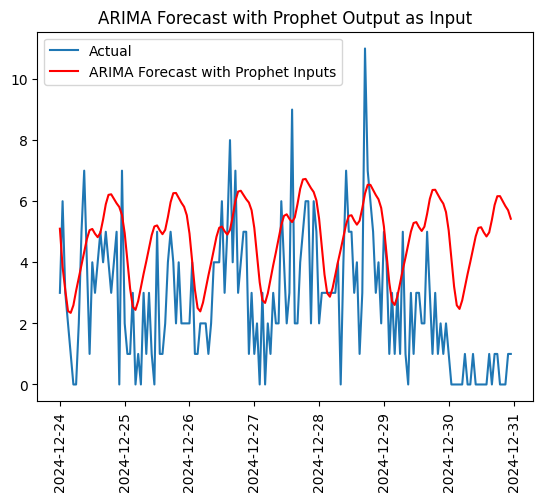

In [ ]:
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, forecast_arima, label='ARIMA Forecast with Prophet Inputs', color='red')
plt.legend()
plt.xticks(rotation=90)
plt.title("ARIMA Forecast with Prophet Output as Input")
plt.show()

In [ ]:
mse_arima = mean_squared_error(test_data, forecast_arima)
rmse_arima = np.sqrt(mse_arima)

model_metrics = {
    'MSE': [mse_arima],
    'RMSE': [rmse_arima]
}

print(model_metrics)

{'MSE': [8.428565342812378], 'RMSE': [2.9031991565878457]}


# 1 Month Forecasting with (5, 1, 0)

In [ ]:
best_prophet_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)

best_prophet_model.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/g6xx5eu7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/i8vy213t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80057', 'data', 'file=/tmp/tmp0tz_j5q6/g6xx5eu7.json', 'init=/tmp/tmp0tz_j5q6/i8vy213t.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_modeldmitv7av/prophet_model-20250310151937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:19:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:23:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = best_prophet_model.make_future_dataframe(periods=720, freq='H')
forecast_prophet = best_prophet_model.predict(future)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [ ]:
prophet_forecast = forecast_prophet.tail(720)['yhat']

In [ ]:
df_resampled = df.resample('H', on='DateTime').size()

<ipython-input-116-3eb0d8b79523>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('H', on='DateTime').size()


In [ ]:
train_data = df_resampled[:-720]
test_data = df_resampled[-720:]

In [ ]:
train_data_with_prophet = train_data.copy()
train_data_with_prophet = train_data_with_prophet.reset_index(drop=True)
train_data_with_prophet = train_data_with_prophet.to_frame(name='y')

In [ ]:
train_data_with_prophet['prophet_forecast'] = np.concatenate([np.zeros(len(train_data)-len(prophet_forecast)), prophet_forecast])

In [ ]:
arima_model = ARIMA(train_data_with_prophet['y'], exog=train_data_with_prophet['prophet_forecast'], order=(5, 1, 0))
arima_model_fit = arima_model.fit()

In [ ]:
forecast_arima = arima_model_fit.forecast(steps=720, exog=prophet_forecast)

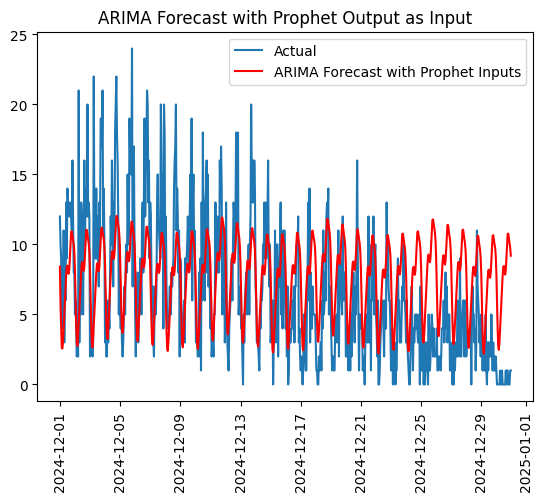

In [ ]:
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, forecast_arima, label='ARIMA Forecast with Prophet Inputs', color='red')
plt.legend()
plt.xticks(rotation=90)
plt.title("ARIMA Forecast with Prophet Output as Input")
plt.show()

In [ ]:
mse_arima = mean_squared_error(test_data, forecast_arima)
rmse_arima = np.sqrt(mse_arima)

model_metrics = {
    'MSE': [mse_arima],
    'RMSE': [rmse_arima]
}

print(model_metrics)

{'MSE': [19.22467985793911], 'RMSE': [4.384595746239225]}


# 24 Hours Forecasting with (6, 1, 0)

In [ ]:
best_prophet_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)

best_prophet_model.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/9q5e93zm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/yqva33fs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57732', 'data', 'file=/tmp/tmp0tz_j5q6/9q5e93zm.json', 'init=/tmp/tmp0tz_j5q6/yqva33fs.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_modelfxn_y1ba/prophet_model-20250310152544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:25:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:30:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = best_prophet_model.make_future_dataframe(periods=24, freq='H')
forecast_prophet = best_prophet_model.predict(future)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [ ]:
prophet_forecast = forecast_prophet.tail(24)['yhat']

In [ ]:
df_resampled = df.resample('H', on='DateTime').size()

<ipython-input-127-3eb0d8b79523>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('H', on='DateTime').size()


In [ ]:
train_data = df_resampled[:-24]
test_data = df_resampled[-24:]

In [ ]:
train_data_with_prophet = train_data.copy()
train_data_with_prophet = train_data_with_prophet.reset_index(drop=True)
train_data_with_prophet = train_data_with_prophet.to_frame(name='y')

In [ ]:
train_data_with_prophet['prophet_forecast'] = np.concatenate([np.zeros(len(train_data)-len(prophet_forecast)), prophet_forecast])

In [ ]:
arima_model = ARIMA(train_data_with_prophet['y'], exog=train_data_with_prophet['prophet_forecast'], order=(6, 1, 0))
arima_model_fit = arima_model.fit()

In [ ]:
forecast_arima = arima_model_fit.forecast(steps=24, exog=prophet_forecast)

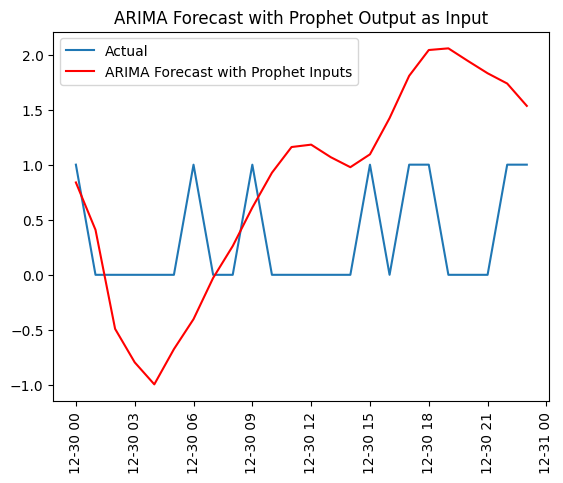

In [ ]:
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, forecast_arima, label='ARIMA Forecast with Prophet Inputs', color='red')
plt.legend()
plt.xticks(rotation=90)
plt.title("ARIMA Forecast with Prophet Output as Input")
plt.show()

In [ ]:
mse_arima = mean_squared_error(test_data, forecast_arima)
rmse_arima = np.sqrt(mse_arima)

model_metrics = {
    'MSE': [mse_arima],
    'RMSE': [rmse_arima]
}

print(model_metrics)

{'MSE': [1.09713883142788], 'RMSE': [1.0474439514493747]}


# 1 Week Forecasting with (6, 1, 0)

In [ ]:
best_prophet_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)

best_prophet_model.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/eb5qmofd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/dbblwda_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87951', 'data', 'file=/tmp/tmp0tz_j5q6/eb5qmofd.json', 'init=/tmp/tmp0tz_j5q6/dbblwda_.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_model1cm38aq7/prophet_model-20250310153223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:32:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:36:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = best_prophet_model.make_future_dataframe(periods=168, freq='H')
forecast_prophet = best_prophet_model.predict(future)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [ ]:
prophet_forecast = forecast_prophet.tail(168)['yhat']

In [ ]:
df_resampled = df.resample('H', on='DateTime').size()

<ipython-input-138-3eb0d8b79523>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('H', on='DateTime').size()


In [ ]:
train_data = df_resampled[:-168]
test_data = df_resampled[-168:]

In [ ]:
train_data_with_prophet = train_data.copy()
train_data_with_prophet = train_data_with_prophet.reset_index(drop=True)
train_data_with_prophet = train_data_with_prophet.to_frame(name='y')

In [ ]:
train_data_with_prophet['prophet_forecast'] = np.concatenate([np.zeros(len(train_data)-len(prophet_forecast)), prophet_forecast])

In [ ]:
arima_model = ARIMA(train_data_with_prophet['y'], exog=train_data_with_prophet['prophet_forecast'], order=(6, 1, 0))
arima_model_fit = arima_model.fit()

In [ ]:
forecast_arima = arima_model_fit.forecast(steps=168, exog=prophet_forecast)

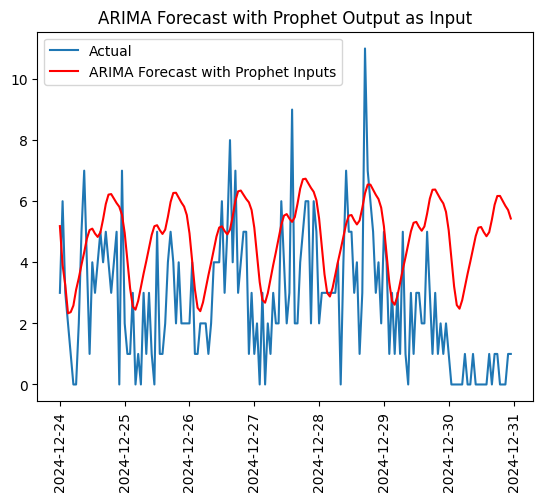

In [ ]:
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, forecast_arima, label='ARIMA Forecast with Prophet Inputs', color='red')
plt.legend()
plt.xticks(rotation=90)
plt.title("ARIMA Forecast with Prophet Output as Input")
plt.show()

In [ ]:
mse_arima = mean_squared_error(test_data, forecast_arima)
rmse_arima = np.sqrt(mse_arima)

model_metrics = {
    'MSE': [mse_arima],
    'RMSE': [rmse_arima]
}

print(model_metrics)

{'MSE': [8.460792805977022], 'RMSE': [2.9087441974118353]}


# 1 Month Forecasting with (6, 1, 0)

In [ ]:
best_prophet_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)

best_prophet_model.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/5w6cmqfo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tz_j5q6/u43xwnyw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41584', 'data', 'file=/tmp/tmp0tz_j5q6/5w6cmqfo.json', 'init=/tmp/tmp0tz_j5q6/u43xwnyw.json', 'output', 'file=/tmp/tmp0tz_j5q6/prophet_modeld0u8dmp8/prophet_model-20250310153806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:38:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
best_prophet_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)

best_prophet_model.fit(df_prophet)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [ ]:
prophet_forecast = forecast_prophet.tail(720)['yhat']

In [ ]:
df_resampled = df.resample('H', on='DateTime').size()

<ipython-input-149-3eb0d8b79523>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('H', on='DateTime').size()


In [ ]:
train_data = df_resampled[:-720]
test_data = df_resampled[-720:]

In [ ]:
train_data_with_prophet = train_data.copy()
train_data_with_prophet = train_data_with_prophet.reset_index(drop=True)
train_data_with_prophet = train_data_with_prophet.to_frame(name='y')

In [ ]:
train_data_with_prophet['prophet_forecast'] = np.concatenate([np.zeros(len(train_data)-len(prophet_forecast)), prophet_forecast])

In [ ]:
arima_model = ARIMA(train_data_with_prophet['y'], exog=train_data_with_prophet['prophet_forecast'], order=(6, 1, 0))
arima_model_fit = arima_model.fit()

In [ ]:
forecast_arima = arima_model_fit.forecast(steps=720, exog=prophet_forecast)

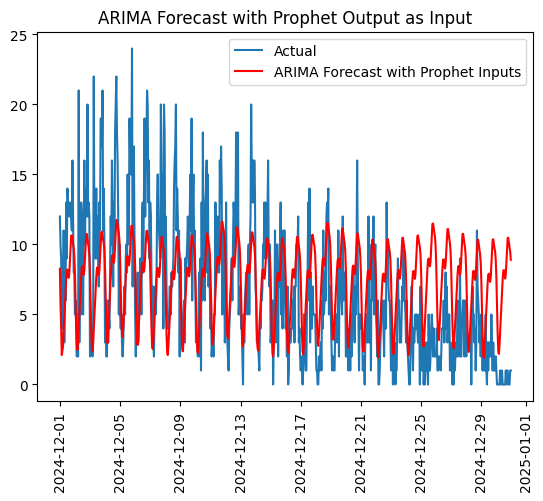

In [ ]:
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, forecast_arima, label='ARIMA Forecast with Prophet Inputs', color='red')
plt.legend()
plt.xticks(rotation=90)
plt.title("ARIMA Forecast with Prophet Output as Input")
plt.show()

In [ ]:
mse_arima = mean_squared_error(test_data, forecast_arima)
rmse_arima = np.sqrt(mse_arima)

model_metrics = {
    'MSE': [mse_arima],
    'RMSE': [rmse_arima]
}

print(model_metrics)

{'MSE': [18.60570277456212], 'RMSE': [4.313432829494638]}
